In [18]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [20]:
num_epoch = 20
epoch_hours = 5
epoch_hours * num_epoch / 24

4.166666666666667

In [2]:
# from glob import glob

# img_paths = sorted(glob('../../../create_synthe_2023/synthetic_flw/flw/*/*'))
# len(img_paths)

# img_paths = sorted(glob('../../../create_synthe_2023/synthetic_flw/mask/*/*.png'))
# len(img_paths)

# img_paths[0]

In [6]:
!pip install -q segmentation_models_pytorch==0.3.3

***
## 本実装


In [1]:
exp_name = 'exp1'

In [2]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F

class ViTEncoder(nn.Module):
    def __init__(self, image_size, patch_size, d_model, nhead, num_encoder_layers, channels=3):
        super(ViTEncoder, self).__init__()

        self.patch_size = patch_size
        self.d_model = d_model
        self.n_patches = (image_size // patch_size) ** 2

        self.embedding = nn.Conv2d(channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, self.n_patches, d_model))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers)

    def forward(self, x):
        # Patch embeddings
        x = self.embedding(x).flatten(2).transpose(1, 2)  # [B, n_patches, d_model]

        # Add positional encodings
        x += self.positional_encoding

        # Pass through transformer
        output = self.transformer(x)

#         return output
        return output.transpose(0, 1)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CustomTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(CustomTransformerDecoderLayer, self).__init__()
#         print(d_model, nhead)
        
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, tgt, memory, tgt_mask=None, tgt_pad_mask=None):
        
        # Self attention with residual connection
        attn_output1, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_pad_mask)
        tgt = self.norm1(tgt + self.dropout(attn_output1))
        
        # Cross attention with residual connection
#         print(f'')
        attn_output2, attn_weight = self.multihead_attn(tgt, memory, memory)
#         attn_output2, attn_weights = self.multihead_attn(tgt, memory, memory, key_padding_mask=tgt_pad_mask)
        tgt = self.norm2(tgt + self.dropout(attn_output2))
        
        # Feed forward with residual connection
        ff_output = self.feed_forward(tgt)
        tgt = tgt + self.dropout(ff_output)
        
#         print('before:', attn_weight.shape)
        attn_weight = self.feed_forward(attn_weight)
        attn_weight = self.feed_forward(attn_weight)
#         print('after:', attn_weight.shape)
        
        return tgt, attn_weight

class CustomTransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_decoder_layers, target_vocab_size, pad_id=-1):
        super(CustomTransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.decoder_layers = nn.ModuleList([CustomTransformerDecoderLayer(d_model, nhead) for _ in range(num_decoder_layers)])
        self.fc_out = nn.Linear(d_model, target_vocab_size)
        self.pad_id = pad_id

    def get_attn_subsequent_mask(self, sz: int) -> torch.Tensor:
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    def forward(self, tgt, memory):
        tgt_pad_mask = (tgt == self.pad_id)
        tgt = self.embedding(tgt) # tgt_after_embedding: [batch, target_len, d_model]
        tgt = self.pos_encoder(tgt)
        
        # create masks, then pass to decoder
        batch_size, target_len, d_model = tgt.shape
        tgt_mask = self.get_attn_subsequent_mask(target_len)

        tgt_mask = tgt_mask.to(tgt.device)

        for i, layer in enumerate(self.decoder_layers):
#             print(i, tgt_pad_mask.shape)
            tgt, attn_weight = layer(tgt, memory, tgt_mask=tgt_mask, tgt_pad_mask=tgt_pad_mask)
            output = self.fc_out(tgt)
        
        return output, attn_weight


class ImageCaptioningModel(nn.Module):
    def __init__(self, image_size, patch_size, d_model, nhead, num_encoder_layers, num_decoder_layers, target_vocab_size, channels=3):
        super(ImageCaptioningModel, self).__init__()
        
        # Encoder
        self.encoder = ViTEncoder(image_size, patch_size, d_model, nhead, num_encoder_layers, channels)

        # Decoder
        self.decoder = CustomTransformerDecoder(d_model, nhead, num_decoder_layers, target_vocab_size)

    def forward(self, img, tgt):
        """
        tgt: [batch, target_len]
        """
        # Encode image
        encoder_output = self.encoder(img) # encoder_output: torch.Size([seq_len, batch, d_model])
#         print(f'encoder_output: {encoder_output.shape}')
        
        # Decode to get the target sequence
        output, cross_attn_maps = self.decoder(tgt, encoder_output)
        
        return output, cross_attn_maps

1.9.0


In [3]:
def calculate_mask_proportions(mask, patch_size, flatten=True):
    B, C, H, W = mask.shape
    mask_proportions = torch.zeros(B, C, H // patch_size, W // patch_size)

    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = mask[:, :, i:i + patch_size, j:j + patch_size]
            proportion = patch.sum(dim=[2, 3]) / (patch_size * patch_size)
            mask_proportions[:, :, i // patch_size, j // patch_size] = proportion
    if flatten:
        B, C, H, W = mask_proportions.shape
        reshaped_mask_proportions = mask_proportions.view(B, C, H * W)
        return reshaped_mask_proportions

    return mask_proportions


In [4]:
import os
import numpy as np
from glob import glob

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

image_size = 256

class OneHotTensorEncode(object):
    def __init__(self, n_classes=11):
        self.n_classes = n_classes

    def __call__(self, mask, debug=False):
        """
        Convert a 1-channel grayscale PIL image with n_classes unique values 
        into an n_classes-channel one-hot encoded tensor.
        """
        mask = np.array(mask)
        one_hot = torch.zeros(self.n_classes, mask.shape[0], mask.shape[1], dtype=torch.float32)
        for i in range(self.n_classes):
            one_hot[i, :, :] = torch.tensor(mask == i, dtype=torch.float32)
            if debug:
                count = np.sum(mask == i)
                print(f"Number of pixels with value {i}: {count}")
            
                plt.imshow(one_hot[i, :, :].numpy(), cmap='gray')
                plt.title(f"Class {i} One-hot Encoded Channel")
                plt.colorbar()
                plt.show()
        return one_hot

class RandomTransformsDual:
    """
    画像とマスクの両方にランダム変換を適用するクラス
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        seed = np.random.randint(2147483647)  # 大きな数でランダムシードを設定
        np.random.seed(seed)  # 同じシードを使用して、画像とマスクの両方に同じ変換を確実に適用する

        for t in self.transforms:
            img = t(img)

        np.random.seed(seed)
        for t in self.transforms:
            mask = t(mask)

        return img, mask
    
def custom_crop(image, trim_margin=180):
    return image.crop((trim_margin, trim_margin, image.width - trim_margin, image.height - trim_margin))

class SegmentationDataset(Dataset):
    def __init__(self, image_glob_path, image_transforms=None, mask_transforms=None, random_transforms=None):
        self.image_glob_path = image_glob_path
#         self.mask_glob_path = mask_glob_path
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.random_transforms = random_transforms
        self.image_paths = sorted(glob(image_glob_path))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = image_path.replace('/flw/', '/mask/')
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.random_transforms:
            image, mask = self.random_transforms(image, mask)

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

random_transforms = RandomTransformsDual([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180)  # ±180度のランダムな回転
])

image_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((image_size, image_size)),
    OneHotTensorEncode(n_classes=11),
])

flw_glob_path = '../../../create_synthe_2023/synthetic_flw/flw/*/*'

# image_glob_path, mask_glob_path, image_transforms=None, mask_transforms=None, random_transforms=None):
dataset = SegmentationDataset(flw_glob_path, image_transforms=image_transforms, mask_transforms=mask_transforms)
dataset_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.3

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
# test_size = dataset_size - train_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# データローダーの作成
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
for flw, mask in val_dataloader:
    break

In [9]:
flw[0].shape, mask[0].shape

(torch.Size([3, 256, 256]), torch.Size([11, 256, 256]))

In [11]:
len(flw[0])

3

In [5]:
import math
import torch
import torch.nn as nn

from tqdm import tqdm
import segmentation_models_pytorch.utils as smp_utils

patch_size = 16

d_model = 256
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
target_vocab_size = 11 # 出現しうる単語数(選択肢の数)
len_out_seq = 11

model = ImageCaptioningModel(image_size, patch_size, d_model, nhead, num_encoder_layers, num_decoder_layers, target_vocab_size)

for i, (images, masks) in enumerate(train_dataloader):
    print(masks.shape)
    break
# target_seq = torch.tensor(
#     [j  if torch.sum(channel) != 0 else target_vocab_size - 1 for i, mask in enumerate(masks) for j, channel in enumerate(mask)]
# ).reshape(masks.shape[:2]).transpose(0, 1)
target_seq = torch.tensor(
    [j  if torch.sum(channel) != 0 else target_vocab_size - 1 for i, mask in enumerate(masks) for j, channel in enumerate(mask)]
).reshape(masks.shape[:2])
print('target_seq', target_seq.shape)

# target_seq = torch.arange(0, target_vocab_size).unsqueeze(1).repeat(1, batch_size)
# print('target_seq', target_seq.shape)

# # Sample input image and target sequence

output, cross_attention_maps = model(images, target_seq)

print(f'target_seq.shape: {target_seq.shape}')
print(f'output.shape: {output.shape}')

torch.Size([16, 11, 256, 256])
target_seq torch.Size([16, 11])
target_seq.shape: torch.Size([16, 11])
output.shape: torch.Size([16, 11, 11])


In [ ]:
# device = torch.device("cpu")
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = smp_utils.losses.DiceLoss().to(device)
# criterion = smp_utils.losses.DiceLoss(ignore_channels=[0]).to(device)
criterion_seq = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    sum_loss_mask = 0
    sum_loss_seq = 0
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}, Train") as pbar_train:
        for i, (images, masks) in enumerate(train_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            target_seq = torch.tensor(
                [j  if torch.sum(channel) != 0 else target_vocab_size - 1 for i, mask in enumerate(masks) for j, channel in enumerate(mask)]
            ).reshape(masks.shape[:2]).to(device)
            mask_proportions = calculate_mask_proportions(masks, patch_size).to(device)

            output, cross_attention_map = model(images, target_seq)
            
            pred_probs = torch.sigmoid(output)
            gt_one_hot = F.one_hot(target_seq, num_classes=11).float()
            loss_seq = F.binary_cross_entropy(pred_probs, gt_one_hot) * 10
            sum_loss_seq += loss_seq
            
#             loss_mask = criterion(cross_attention_map, mask_proportions)
            loss_mask = criterion(cross_attention_map[:, 1:, :], mask_proportions[:, 1:, :])
            sum_loss_mask += loss_mask
            
            loss = loss_mask  + loss_seq

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar_train.set_postfix({"Train Loss": loss.item()})
            pbar_train.update(1)
    print(f'loss_mask: {sum_loss_mask / (i + 1)}')
    print(f'loss_seq: {sum_loss_seq / (i + 1)}')

    model.eval()
    sum_loss_mask = 0
    sum_loss_seq = 0
    total_val_accuracy = 0
    with tqdm(total=len(val_dataloader), desc=f"Epoch {epoch + 1} / {num_epochs}, Val") as pbar_val:
        for i, (images, masks) in enumerate(val_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            target_seq = torch.tensor(
                [j  if torch.sum(channel) != 0 else target_vocab_size - 1 for i, mask in enumerate(masks) for j, channel in enumerate(mask)]
            ).reshape(masks.shape[:2]).to(device)
            mask_proportions = calculate_mask_proportions(masks, patch_size).to(device)
            
            output, cross_attention_map = model(images, target_seq)
            
            pred_probs = torch.sigmoid(output)
            gt_one_hot = F.one_hot(target_seq, num_classes=11).float()
            loss_seq = F.binary_cross_entropy(pred_probs, gt_one_hot) * 10
            sum_loss_seq += loss_seq
            
#             loss_mask = criterion(cross_attention_map, mask_proportions)
            loss_mask = criterion(cross_attention_map[:, 1:, :], mask_proportions[:, 1:, :])
            sum_loss_mask += loss_mask
            
#             loss = loss_mask
            loss = loss_mask + loss_seq
#             loss = loss_seq
            
            pbar_val.set_postfix({"Val Loss": loss.item()})
            pbar_val.update(1)
    print(f'loss_mask: {sum_loss_mask / (i + 1)}')
    print(f'loss_seq: {sum_loss_seq / (i + 1)}')
    
    if (epoch + 1) % 5 == 0:
        save_path = f'./models/{exp_name}_epoch{epoch + 1}'
        torch.save(model.state_dict(), save_path)


Epoch 1/20, Train:   1%|          | 131/21875 [01:47<4:38:45,  1.30it/s, Train Loss=1.03]  

## load model

In [ ]:
# model_ = ImageCaptioningModel(image_size, patch_size, d_model, nhead, num_encoder_layers, num_decoder_layers, target_vocab_size)
# model_.load_state_dict(torch.load(save_path))
# model_

In [ ]:
# torch.save(the_model.state_dict(), PATH)

# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load(PATH))


In [ ]:
cross_attention_maps.to('cpu')[0]

In [ ]:
cross_attention_maps.to('cpu')[0].shape

In [ ]:
cross_attention_maps[:, 1:, :].shape

In [ ]:
for channel in cross_attention_maps.to('cpu')[0]:
    print(channel)
    break

In [ ]:
for channel in mask_proportions.to('cpu')[0]:
    print(channel)
    break

In [ ]:
for i in 

In [11]:
predicted_indices = torch.argmax(pred_probs, dim=-1)
predicted_indices

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10]], device='cuda:2')

In [25]:
loss_mask

tensor(2.9710, device='cuda:2', grad_fn=<AddBackward0>)

In [26]:
loss_seq

tensor(0.2592, device='cuda:2', grad_fn=<BinaryCrossEntropyBackward>)

In [23]:
predicted_indices = torch.argmax(pred_probs, dim=-1)
predicted_indices

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]], device='cuda:2')

In [17]:
loss_seq

tensor(0.2662, device='cuda:2', grad_fn=<BinaryCrossEntropyBackward>)

In [18]:
loss_mask

tensor(2.9672, device='cuda:2', grad_fn=<AddBackward0>)

In [19]:
loss_seq

tensor(0.7469, device='cuda:2')

In [13]:
import torch.nn.functional as F
print(predicted_indices.shape)
pred_one_hot = F.one_hot(predicted_indices).float()
gt_one_hot = F.one_hot(target_seq).float()
loss = F.binary_cross_entropy_with_logits(pred_one_hot, gt_one_hot)

print(loss)

torch.Size([12, 11])
tensor(0.7357)


In [9]:
target_seq

tensor([[ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5, 10, 10, 10, 10, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7, 10, 10, 10]])

In [ ]:
import torch
import matplotlib.pyplot as plt

def recreate_image_from_attention(cross_attention_map, img_size, patch_size):
    """
    cross_attention_map: shape [11, 1024] (or any [channel_out, flattened_img_size])
    img_size: Original image size (e.g., 224 for a 224x224 image)
    patch_size: The size of each patch (e.g., 16 for 16x16 patches)
    """
    channel_out, flattened_img_size = cross_attention_map.shape
    patches_per_dim = img_size // patch_size
    
    # Reshape to [channel_out, patches_per_dim, patches_per_dim]
    reshaped_attention_map = cross_attention_map.view(channel_out, patches_per_dim, patches_per_dim)
    
    # Initialize tensor to store the recreated image
    recreated_images = torch.zeros((channel_out, img_size, img_size))
    
    # Fill in the recreated image tensor
    for i in range(patches_per_dim):
        for j in range(patches_per_dim):
            recreated_images[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = reshaped_attention_map[:, i, j].unsqueeze(1).unsqueeze(2)
            
    return recreated_images


# Call the function
recreated_images = recreate_image_from_attention(cross_attention_maps[0][0], image_size, patch_size)

# Visualize
for i in range(recreated_images.shape[0]):
    plt.figure()
    plt.imshow(recreated_images[i].detach().numpy(), cmap="gray")
    plt.title(f"Channel {i}")
    plt.show()


In [ ]:
recreated_images = recreate_image_from_attention(mask_proportions[0], image_size, patch_size)

# Visualize
for i in range(recreated_images.shape[0]):
    plt.figure()
    plt.imshow(recreated_images[i].detach().numpy(), cmap="gray")
    plt.title(f"Channel {i}")
    plt.show()


### simple test


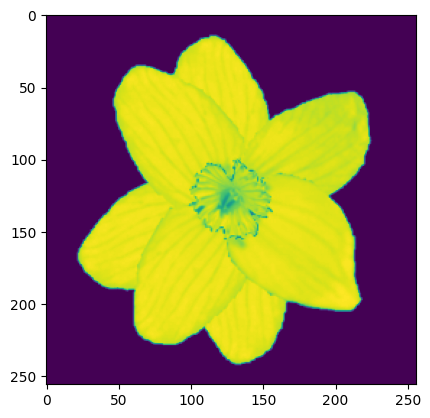

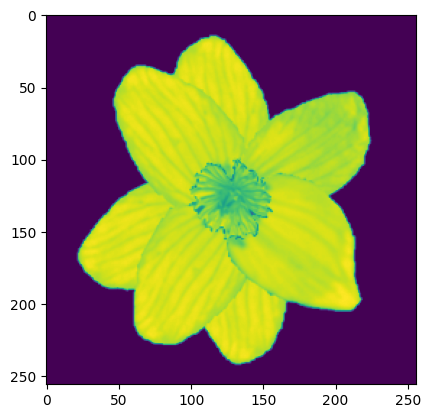

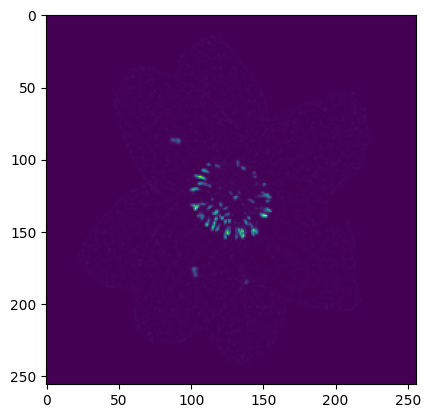

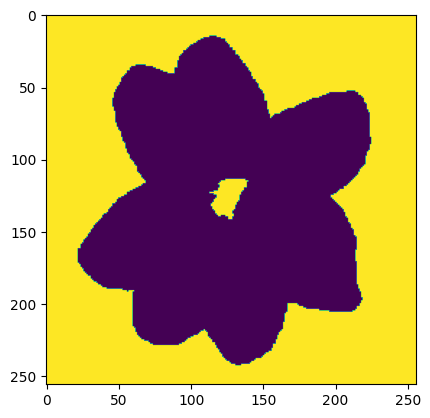

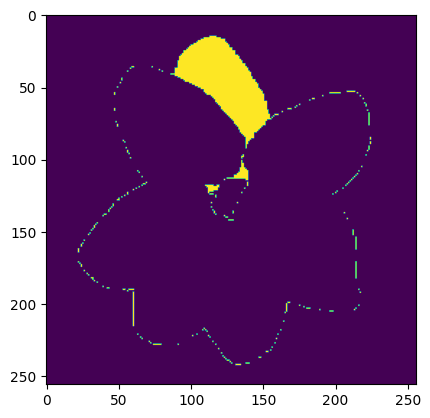

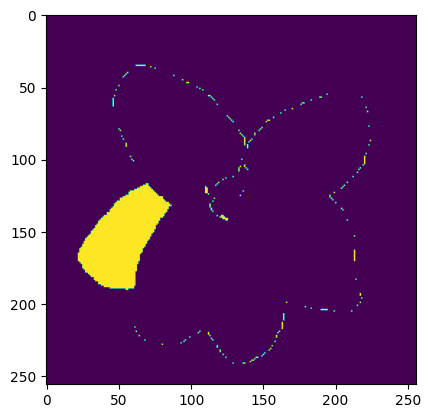

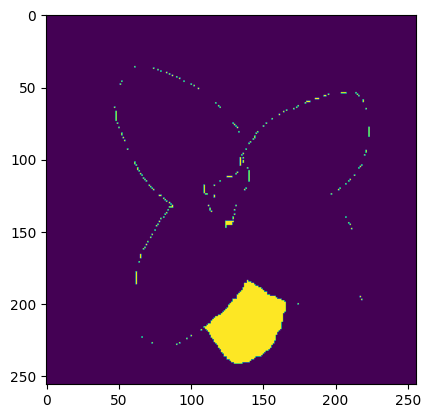

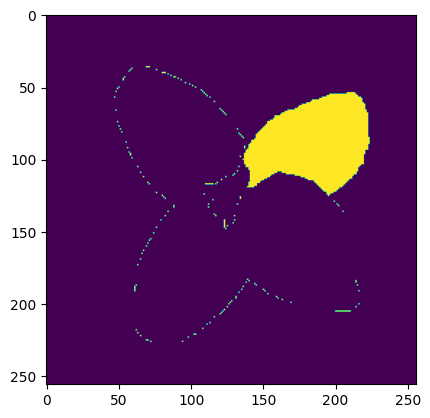

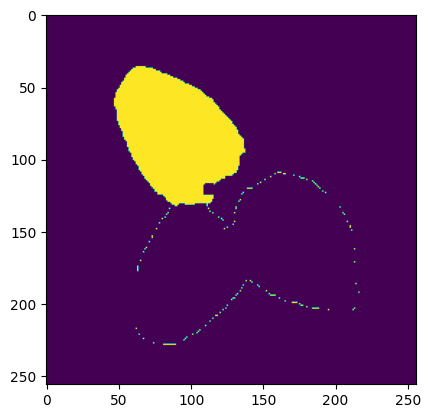

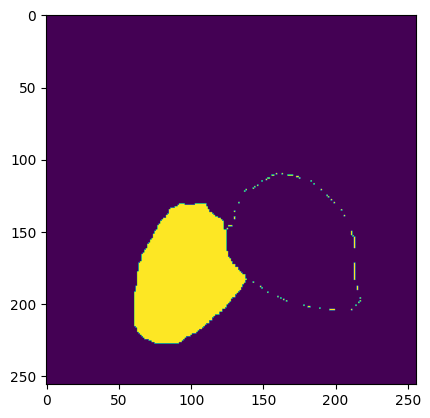

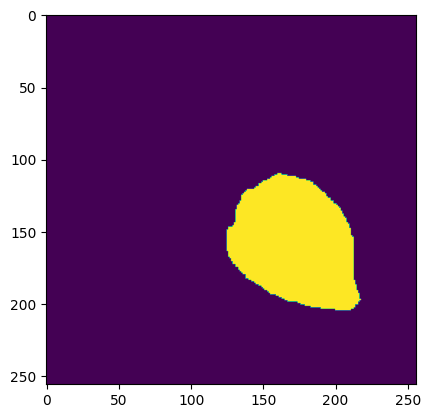

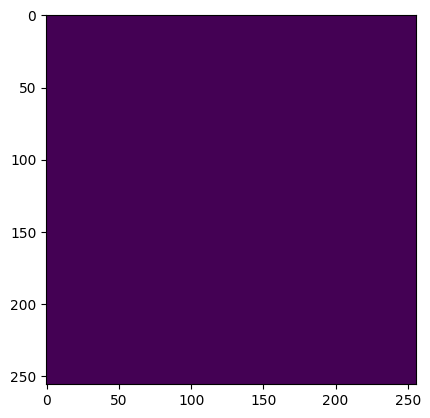

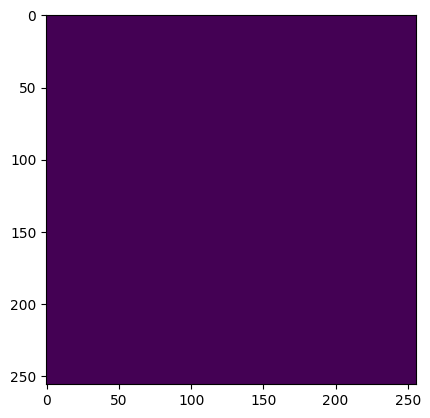

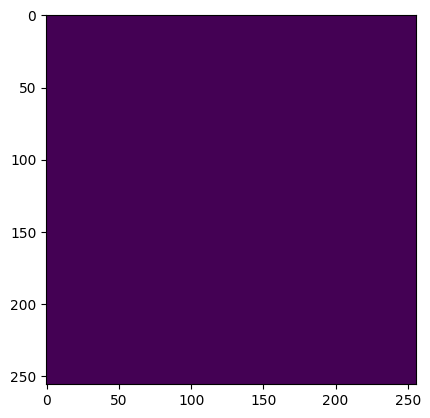

In [14]:
import matplotlib.pyplot as plt
for c in flw[0]:
    plt.imshow(c)
    plt.show()

for c in mask[0]:
    plt.imshow(c)
    plt.show()

## Idea 



* クラスラベルの順列を出力系列とするのは、あまりに難しそう。
* docoderに入力するのは、各パッチの特徴を並べたもの

target_seqの系列長と最終的に出力してほしいsequence_lengthは一般には同じである必要はありません。Transformerモデルの訓練時においては、通常、ターゲット系列（target_seq）は入力として使われるだけでなく、訓練のラベルとしても使用されます。その場合、target_seqの系列長は出力と一致するように設計されることが多いです。

しかし、推論（予測）時には、通常、開始トークンだけをtarget_seqとして使用し、モデルがその後のトークンを一つずつ生成するようにします。この場合、target_seqの初期の長さは1であり、出力のsequence_lengthは1から始まって任意の長さになり得ます（停止条件または最大長に達するまで）。

簡単に言うと、訓練と推論でtarget_seqの役割が少し異なるため、その長さもそれに応じて変わります。

In [52]:
predicted_indices = torch.argmax(output, dim=-1)
predicted_indices.shape == target_seq.shape

True